In [1]:
# Mapping Isochrones Around Park Entrances
# Author: Katrina Deloso
# In this notebook, I will identify the coordinate points around a park's entrances and build isochrones for 5, 10, 15, and 20 minute walks
# This notebook will serve as a pilot for our project goal, to map isochrones for walking and public transit around 17 regional parks in LA County
# I will be using Griffith Park as the pilot park, and mapping from the Vermont gate (34.117089, -118.297918) and the Ferndell/Western Canyon gate (34.109361162302825, -118.30763412707273)

In [2]:
# I begin by importing libraries for: spatial data, plotting, network analysis, street network analysis, and basemaps

import geopandas as gpd

import matplotlib.pyplot as plt

import networkx as nx

import osmnx as ox

import contextily as ctx

In [3]:
# configure the place, network type, trip times, and travel speed
# Since I'm mapping from coordinates, I use the coordinates as the place
# I'm only creating isochrones for 5 and 10 minute walks, since we'll be combining walk time with public transit time
center_point = (34.117089, -118.297918)
network_type = 'walk'
trip_times = [5, 10] #in minutes
meters_per_minute = 75 # travel distance per minute

In [4]:
%%time

# download the street network
# Since I'm graphing from coordinates, I use "graph_from_point" instead of "graph_from_place"
G = ox.graph_from_point(center_point, dist = 2000, network_type='walk')

CPU times: user 5.45 s, sys: 159 ms, total: 5.61 s
Wall time: 12 s


In [5]:
type(G)

networkx.classes.multidigraph.MultiDiGraph

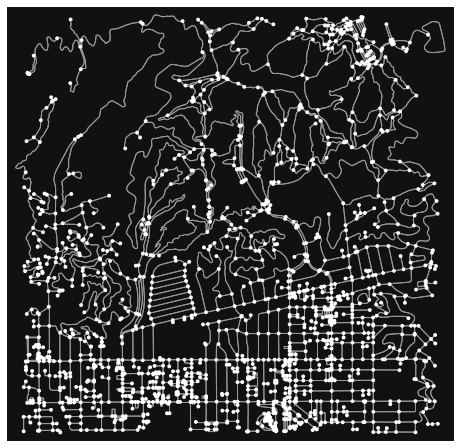

In [6]:
# quick plot using oxmnx
fig, ax = ox.plot_graph(G)

In [7]:
# project our network data to Web Mercator (measurements are in meters)
G = ox.project_graph(G, to_crs='epsg:3857')

In [8]:
# convert nodes and edges to geodataframes
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

In [9]:
# snapshot of nodes
gdf_nodes.head()

,y,x,osmid,highway,lon,lat,geometry
20842309,4.042964e+06,-1.316818e+07,20842309,traffic_signals,-118.291800,34.105406,POINT (-13168182.930 4042964.219)
20842310,4.043728e+06,-1.316819e+07,20842310,traffic_signals,-118.291819,34.111085,POINT (-13168185.023 4043727.825)
20842311,4.043835e+06,-1.316770e+07,20842311,traffic_signals,-118.287462,34.111886,POINT (-13167700.015 4043835.495)
20842312,4.043998e+06,-1.316697e+07,20842312,traffic_signals,-118.280900,34.113093,POINT (-13166969.570 4043997.848)
20954382,4.044176e+06,-1.316750e+07,20954382,NaN,-118.285642,34.114416,POINT (-13167497.480 4044175.639)


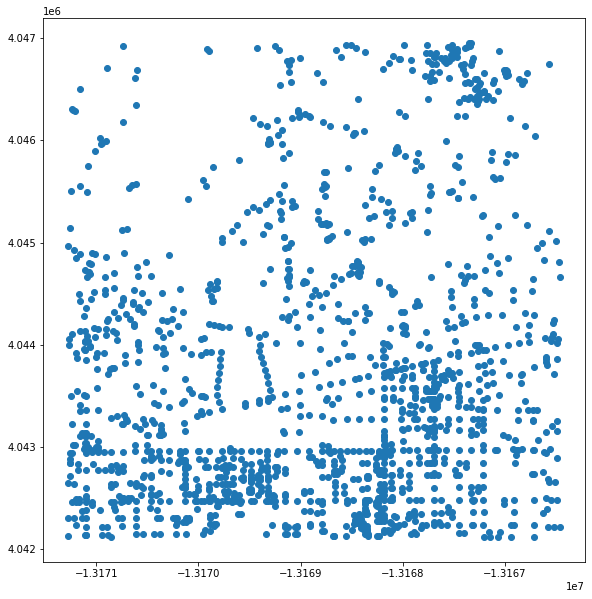

In [10]:
# plot nodes
gdf_nodes.plot(figsize=(10,10))

In [11]:
# snapshot edges
gdf_edges.head()

,osmid,lanes,name,highway,oneway,length,geometry,maxspeed,bridge,service,tunnel,access,width,u,v,key
0,398186772,3,Franklin Avenue,tertiary,False,22.862,"LINESTRING (-13168182.930 4042964.219, -131681...",NaN,NaN,NaN,NaN,NaN,NaN,20842309,7874168492,0
1,398194779,5,North Vermont Avenue,secondary,False,48.794,"LINESTRING (-13168182.930 4042964.219, -131681...",NaN,NaN,NaN,NaN,NaN,NaN,20842309,1695485512,0
2,398194780,5,North Vermont Avenue,secondary,False,25.490,"LINESTRING (-13168182.930 4042964.219, -131681...",NaN,NaN,NaN,NaN,NaN,NaN,20842309,7874168496,0
3,"[398186768, 398186769]","[2, 3]",Franklin Avenue,tertiary,False,43.751,"LINESTRING (-13168182.930 4042964.219, -131682...",NaN,NaN,NaN,NaN,NaN,NaN,20842309,1671438346,0
4,169053303,6,Los Feliz Boulevard,primary,False,25.358,"LINESTRING (-13168185.023 4043727.825, -131681...",NaN,NaN,NaN,NaN,NaN,NaN,20842310,2296303656,0


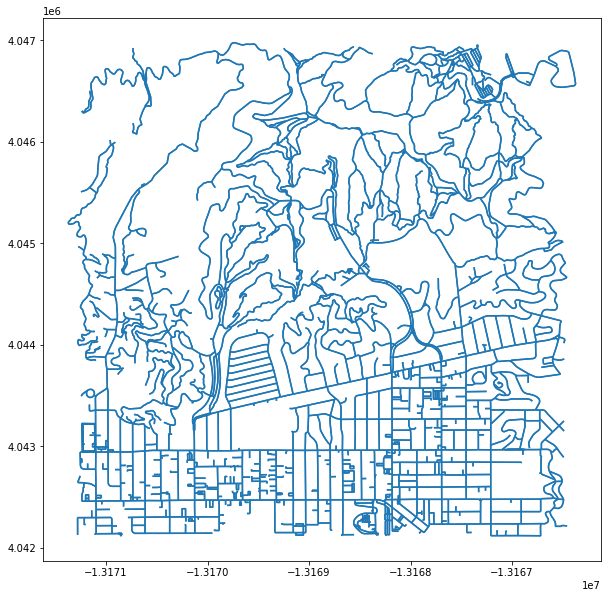

In [12]:
# plot edges
gdf_edges.plot(figsize=(10,10))

In [13]:
# get info on what streets (aka 'highways') are like
gdf_edges['highway'].value_counts()

residential                      1486
service                          1028
footway                           282
track                             272
primary                           238
tertiary                          234
secondary                         154
path                              150
unclassified                      146
steps                              32
[steps, footway]                   14
[steps, residential]               12
living_street                      12
primary_link                        6
[path, residential]                 4
[track, path]                       3
[path, track]                       3
[track, footway]                    2
[unclassified, residential]         2
[tertiary, residential]             2
[path, footway]                     2
[primary, residential]              2
[service, footway]                  2
[footway, service]                  2
[track, service]                    2
[track, residential]                2
[path, steps

In [14]:
# how many streets are there?
gdf_edges['highway'].count()

4102

In [15]:
# Calculate network statistics
stats = ox.basic_stats(G, circuity_dist='euclidean')
stats

{'n': 1556,
 'm': 4102,
 'k_avg': 5.272493573264781,
 'intersection_count': 1238,
 'streets_per_node_avg': 2.7075835475578405,
 'streets_per_node_counts': {0: 0, 1: 318, 2: 0, 3: 1065, 4: 166, 5: 6, 6: 1},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.2043701799485861,
  2: 0.0,
  3: 0.6844473007712082,
  4: 0.10668380462724936,
  5: 0.0038560411311053984,
  6: 0.0006426735218508997},
 'edge_length_total': 416828.91600000084,
 'edge_length_avg': 101.61602047781591,
 'street_length_total': 208414.45799999958,
 'street_length_avg': 101.6160204778155,
 'street_segments_count': 2051,
 'node_density_km': None,
 'intersection_density_km': None,
 'edge_density_km': None,
 'street_density_km': None,
 'circuity_avg': 0.9668496827248331,
 'self_loop_proportion': 0.0039005363237445147,
 'clean_intersection_count': None,
 'clean_intersection_density_km': None}

In [16]:
# Since I'm mapping from a set of coordinates and its radius of 2000m, I find the centroid node from the set of coordinates
# I first try the euclidean method, but that turns out a node quite far from my coordinates
# I try again with the haversine method, but that produces a different node that's still far from my coordinates
center_node = ox.get_nearest_node(G, 
                                  (-118.297918, 34.117089), 
                                  method = 'euclidean', 
                                  return_dist=True)
print('The id for the nearest node is ' + str(center_node))
# using the "return dist" function tells me that that node is 1377.2863km from my coordinates

The id for the nearest node is (26705245, 13773053.622633679)


In [17]:
# re-run cell without distance so that I can use it as a point
center_node = ox.get_nearest_node(G, 
                                  (-118.297918, 34.117089), 
                                  method = 'euclidean')
print('The id for the nearest node is ' + str(center_node))

The id for the nearest node is 26705245


In [18]:
# what is this record?
gdf_nodes.loc[[center_node]]

,y,x,osmid,highway,lon,lat,geometry
26705245,4.042218e+06,-1.316646e+07,26705245,NaN,-118.276308,34.099853,POINT (-13166458.402 4042217.765)


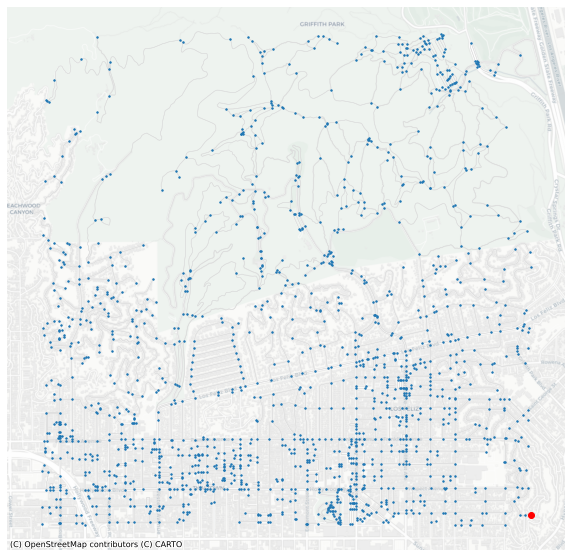

In [19]:
# map it

fig, ax = plt.subplots(figsize=(10,10))

gdf_edges.plot(ax=ax,
               linewidth=0.5,
               edgecolor='gainsboro', 
               zorder=10)

gdf_nodes.plot(ax=ax, 
               markersize=2, 
               zorder=20)

gdf_nodes.loc[[26705245]].plot(ax=ax,
                                  color='r', 
                                  zorder=30)

ax.axis('off')

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [20]:
# Since that didn't work, I go back to finding the centroid node like we did in class

# find the bounds
minx, miny, maxx, maxy = gdf_nodes.geometry.total_bounds
# calculate the centroid
centroid_x = (maxx-minx)/2 + minx
centroid_y = (maxy-miny)/2 + miny
print(centroid_x)
print(centroid_y)

# use osmnx's get_nearest_node command to get the id for the nearest node
center_node2 = ox.get_nearest_node(G, 
                                  (centroid_y,centroid_x), 
                                  method = 'euclidean')
print('The id for the nearest node is ' + str(center_node))

-13168869.381527785
4044535.2782326164
The id for the nearest node is 26705245


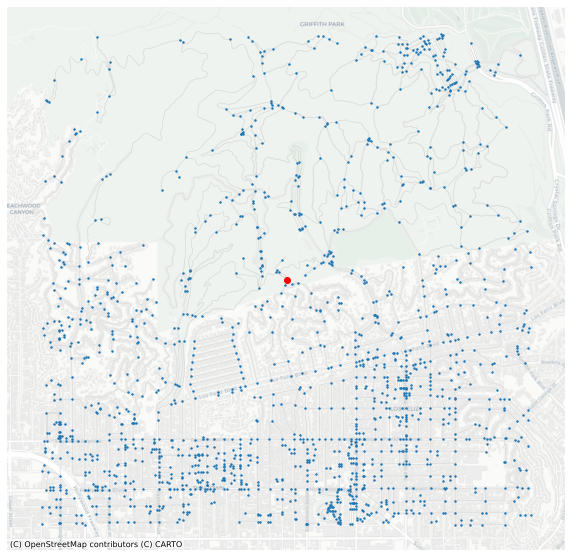

In [21]:
# set up the subplot (single plot = ax)
fig, ax = plt.subplots(figsize=(10,10))

# add the edges to ax
gdf_edges.plot(ax=ax,
               linewidth=0.5,
               edgecolor='gainsboro', 
               zorder=10)

# add all nodes to ax
gdf_nodes.plot(ax=ax, 
               markersize=2, 
               zorder=20)

# add the center node in red also to ax
gdf_nodes.loc[[center_node2]].plot(ax=ax,
                                  color='r', 
                                  zorder=30)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [22]:
# snapshot of edge data
gdf_edges[['osmid','name','highway','length']].sample(5)

,osmid,name,highway,length
558,13458576,North Hobart Boulevard,residential,64.887
40,172083747,Vermont Avenue,unclassified,170.583
2517,"[220641160, 220641159]",NaN,service,49.137
2592,"[863698672, 338568792]",NaN,footway,419.471
2182,844569749,Vermont Canyon Road,unclassified,72.602


In [23]:
# create a new column (using gdf['new column title'])
# calculate the time it takes to travel that edge
gdf_edges['walk_time'] = gdf_edges['length']/meters_per_minute

In [24]:
# spotcheck walk time column
gdf_edges[['osmid','name','highway','length','walk_time']].sample(10)

,osmid,name,highway,length,walk_time
498,13459723,Myra Avenue,residential,157.579,2.101053
4020,"[882405040, 882405039]",NaN,service,54.306,0.724080
696,18256889,East Live Oak Drive,residential,374.443,4.992573
1513,130510379,NaN,footway,60.587,0.807827
164,"[398186780, 398186775]",Hollywood Boulevard,primary,100.220,1.336267
1508,130510352,NaN,track,17.863,0.238173
675,179810903,Spring Oak Drive,residential,218.269,2.910253
2818,489662080,NaN,service,43.332,0.577760
2916,579983268,NaN,service,38.063,0.507507
1055,13457811,North Alexandria Avenue,residential,85.410,1.138800


In [25]:
# assign a color hex code for each trip time isochrone
# len(trip_times) = 4 - this is another way to get 4 colors
iso_colors = ox.plot.get_colors(n=len(trip_times), 
                                cmap='viridis', 
                                start=0, 
                                return_hex=True)
print(trip_times)
print(iso_colors)

[5, 10]
['#440154', '#fde725']


In [26]:
# create a list of "zipped" time/colors
# these are called tuples - pairs of values
time_color = list(zip(trip_times, iso_colors))
time_color

[(5, '#440154'), (10, '#fde725')]

In [27]:
time_color.sort(reverse=True)
print(time_color)

[(10, '#fde725'), (5, '#440154')]


In [28]:
# loop through the list of time/colors
for time,color in list(time_color):
    print('The color for '+str(time)+' minutes is ' + color)

The color for 10 minutes is #fde725
The color for 5 minutes is #440154


In [29]:
# loop through each trip time and associated color
for time, color in list(time_color):

    # for each trip time, create an egograph of nodes that fall within that distance
    subgraph = nx.ego_graph(G, center_node2, radius=time, distance='time')

    print('There are ' + str(len(subgraph.nodes())) + ' nodes within ' + str(time) + ' minutes ')
    
    # for each of those nodes, update the gdf_nodes dataframe and assign it with its associated distance color
    for node in subgraph.nodes():
        gdf_nodes.loc[node,'time'] = str(time) + ' mins'
        gdf_nodes.loc[node,'color'] = color
        
    # start with the farthest nodes, then override this each time you try to find nodes within a shorter distance

There are 224 nodes within 10 minutes 
There are 42 nodes within 5 minutes 


In [30]:
# spot check
gdf_nodes[['osmid','highway','time','color']].sample(20)

,osmid,highway,time,color
123300000,123300000,NaN,NaN,NaN
26079313,26079313,NaN,NaN,NaN
8166849286,8166849286,NaN,10 mins,#fde725
2296551674,2296551674,NaN,NaN,NaN
26079352,26079352,turning_circle,NaN,NaN
6819487108,6819487108,NaN,NaN,NaN
6807557531,6807557531,NaN,NaN,NaN
6798312195,6798312195,NaN,10 mins,#fde725
1045481299,1045481299,NaN,10 mins,#fde725
6734781634,6734781634,NaN,NaN,NaN


In [31]:
# assign NaN values as a grey color
gdf_nodes['color'].fillna('#cccccc', inplace=True)

In [32]:
#spot check
gdf_nodes[['osmid','highway','time','color']].sample(5)

,osmid,highway,time,color
3253152596,3253152596,NaN,NaN,#cccccc
188234682,188234682,NaN,NaN,#cccccc
6726443404,6726443404,NaN,NaN,#cccccc
123176107,123176107,NaN,NaN,#cccccc
123060845,123060845,NaN,NaN,#cccccc


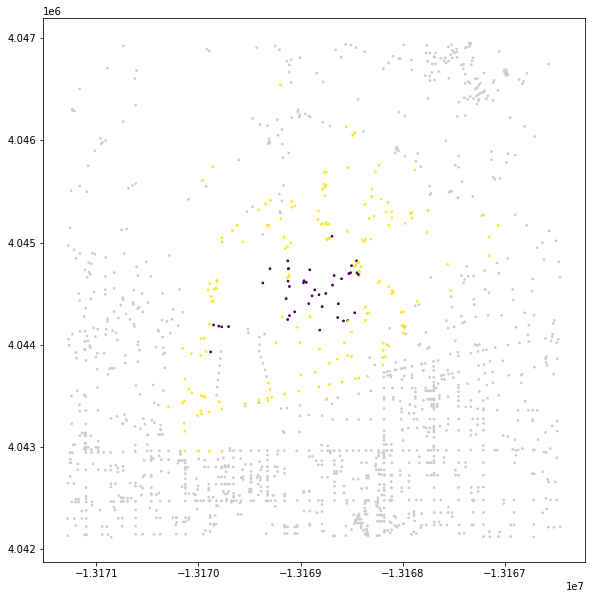

In [33]:
# map it
gdf_nodes.plot(figsize=(10,10),
               color=gdf_nodes['color'],
               markersize=3)

In [34]:
# create a list of nodes within a 5 minute walk
gdf_5 = gdf_nodes[gdf_nodes['time']=='5 mins']

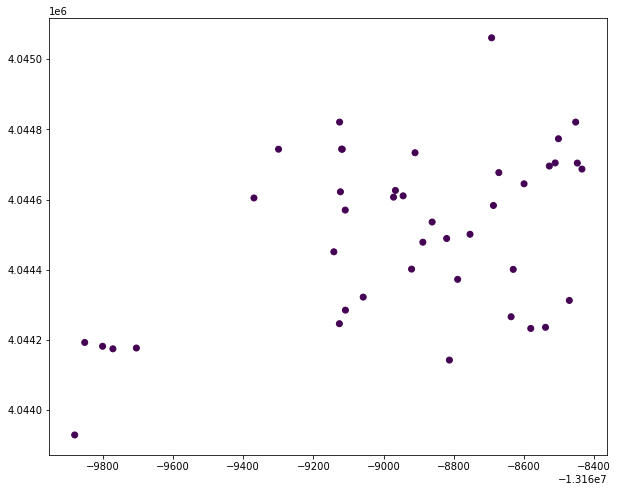

In [35]:
# plot it
gdf_5.plot(figsize=(10,10),color=gdf_5.color)

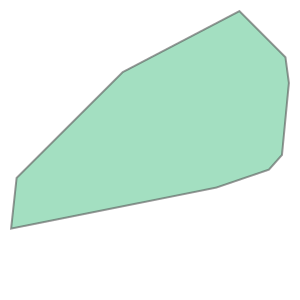

In [36]:
# combine all the points (.unary_union) and create a convex hull polygon (.convex_hull)
gdf_5.unary_union.convex_hull

In [37]:
# dissolve (collapse/group) the nodes by time
isochrones = gdf_nodes.dissolve("time")
isochrones

,geometry,y,x,osmid,highway,lon,lat,color
time,,,,,,,,
10 mins,"MULTIPOINT (-13170291.911 4043388.797, -131701...",4.044514e+06,-1.316809e+07,20954400,traffic_signals,-118.290957,34.116933,#fde725
5 mins,"MULTIPOINT (-13169880.329 4043929.182, -131698...",4.044773e+06,-1.316850e+07,20954405,NaN,-118.294664,34.118861,#440154


In [38]:
# for each row, create a convex hull
isochrones = isochrones.convex_hull.reset_index()
isochrones

,time,0
0,10 mins,"POLYGON ((-13169893.220 4042957.470, -13170007..."
1,5 mins,"POLYGON ((-13169880.329 4043929.182, -13169851..."


In [39]:
# rename columns as 'time' and 'geometry'
isochrones.columns=['time','geometry']
#spot check
isochrones

,time,geometry
0,10 mins,"POLYGON ((-13169893.220 4042957.470, -13170007..."
1,5 mins,"POLYGON ((-13169880.329 4043929.182, -13169851..."


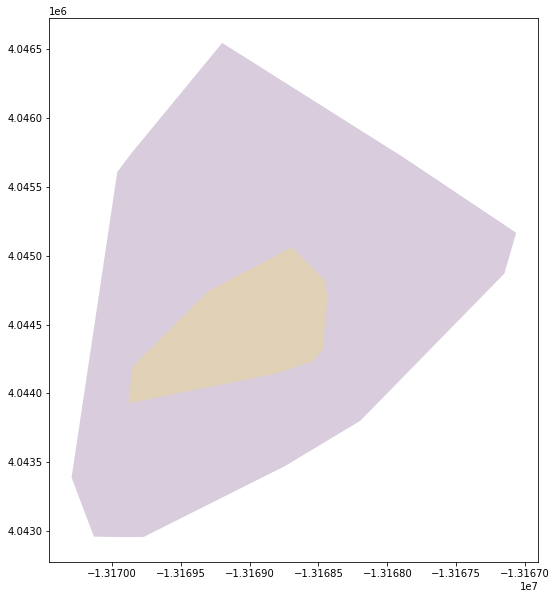

In [40]:
# map the isochrones!
isochrones.plot(figsize=(10,10),alpha=0.2,cmap='viridis')

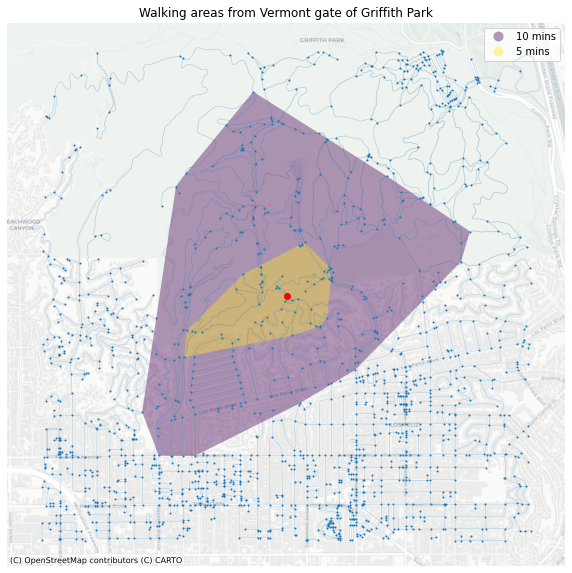

In [41]:
# Full isochrone map

# set up the subplots
fig, ax = plt.subplots(figsize=(10,15))

# add the isochrones
# for submaps, need ax=ax(because ax=subplot)
isochrones.plot(alpha=0.4, 
                ax=ax, 
                column='time', 
                cmap='viridis', 
                legend=True,
                zorder=1)

# add the center node in red
gdf_nodes.loc[[center_node2]].plot(ax=ax,color='r', zorder=30)

# add all nodes
gdf_nodes.plot(ax=ax, 
               markersize=1, 
               zorder=10)

# add the edges
gdf_edges.plot(ax=ax,
               linewidth=0.5,
               alpha=0.2,
               zorder=10)

# hide the axis
ax.axis('off')

# give it a title
ax.set_title('Walking areas from Vermont gate of Griffith Park')

# add the basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [42]:
# import more libraries for geometry shapes
from shapely.geometry import Point, LineString, Polygon
from descartes import PolygonPatch

In [43]:
# make a better isochrone
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node2, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': list(subgraph.nodes)}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get('geometry',  LineString([f,t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

In [44]:
isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)

In [45]:
# Create an empty geopandas GeoDataFrame
better_isos = gpd.GeoDataFrame()
better_isos['geometry'] = None

In [46]:
# Need to sort trip times in reverse so that it starts with 20 min walkshed first
trip_times.sort(reverse=True)
print(time_color)

[(10, '#fde725'), (5, '#440154')]


In [47]:
for i in range(len(isochrone_polys)):
    better_isos.loc[i,'geometry'] = isochrone_polys[i]
    better_isos.loc[i,'time'] =  str(trip_times[i]) + ' mins'
better_isos

,geometry,time
0,"POLYGON ((-13169747.315 4043351.644, -13169747...",10 mins
1,"POLYGON ((-13169746.229 4044160.437, -13169746...",5 mins


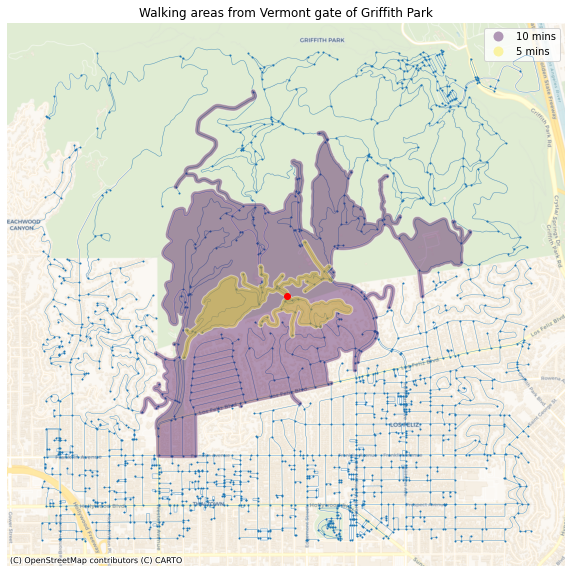

In [50]:
# Plot isochrones!
# Set up subplots
fig, ax = plt.subplots(figsize=(10,15))

# Add isochrones
better_isos.plot(alpha=0.4, 
                ax=ax, 
                column='time', 
                cmap='viridis', 
                edgecolor='white',
                 legend=True,
                zorder=20)

# Add center node
gdf_nodes.loc[[center_node2]].plot(ax=ax,color='r', zorder=30)

# Add nodes
gdf_nodes.plot(ax=ax, 
                markersize=1, 
                zorder=1)

# Add edges
gdf_edges.plot(ax=ax,
               linewidth=0.5,
               alpha=0.4,
               zorder=10)

# Hide axis
ax.axis('off')

# Title
ax.set_title('Walking areas from Vermont gate of Griffith Park')

# add the basemap
# Here, changing the map from Positron to Voyager to better see the park boundaries
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Voyager)